# Predict Student Earnings -- Microsoft Data Science Capstone Challenge

## Information

- [Homepage of Competition](https://datasciencecapstone.org/competitions/2/student-earnings/page/5/)
- [Problem Description](https://datasciencecapstone.org/competitions/2/student-earnings/page/6/)
- [LeaderBoard of Public Score](https://datasciencecapstone.org/competitions/2/student-earnings/leaderboard/)

## General Idea of Solution

1. Minimum data wrangling
2. Single decision tree regressor as benchmark
3. Iteration for further data wrangling tactic, feature engineering and single model selection
4. Stacking models

## Step 1: Minimum Data Wrangling

### 1.1 Gathering / Importing

In [220]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [221]:
X_train = pd.read_csv('train_values.csv', header = 0, index_col = 0)
y_train = pd.read_csv('train_labels.csv', header = 0, index_col = 0)
X_test = pd.read_csv('test_values.csv', header = 0, index_col = 0)

### 1.2 Assessing

In [222]:
# Concatenate X_train and X_test
X_conc = pd.concat([X_train, X_test])
X_conc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26299 entries, 0 to 26298
Columns: 297 entries, academics__program_assoc_agriculture to student__size
dtypes: float64(287), int64(1), object(9)
memory usage: 59.8+ MB


In [223]:
# Check dtypes
X_conc.dtypes.value_counts()

float64    287
object       9
int64        1
dtype: int64

In [224]:
object_list = X_conc.columns[X_train.dtypes=='object'].tolist()
print (object_list)

['report_year', 'school__degrees_awarded_highest', 'school__degrees_awarded_predominant', 'school__institutional_characteristics_level', 'school__main_campus', 'school__online_only', 'school__ownership', 'school__region_id', 'school__state']


In [276]:
# Check duplicate
X_conc[X_conc.duplicated(keep=False)].isnull().sum(axis=1).sort_values().head(5)

# duplicated rows returned have extreme high portion of missing data
# so cannot judge whether it is real duplicated or not

row_id
19460    274
19919    274
3129     274
6157     274
3571     274
dtype: int64

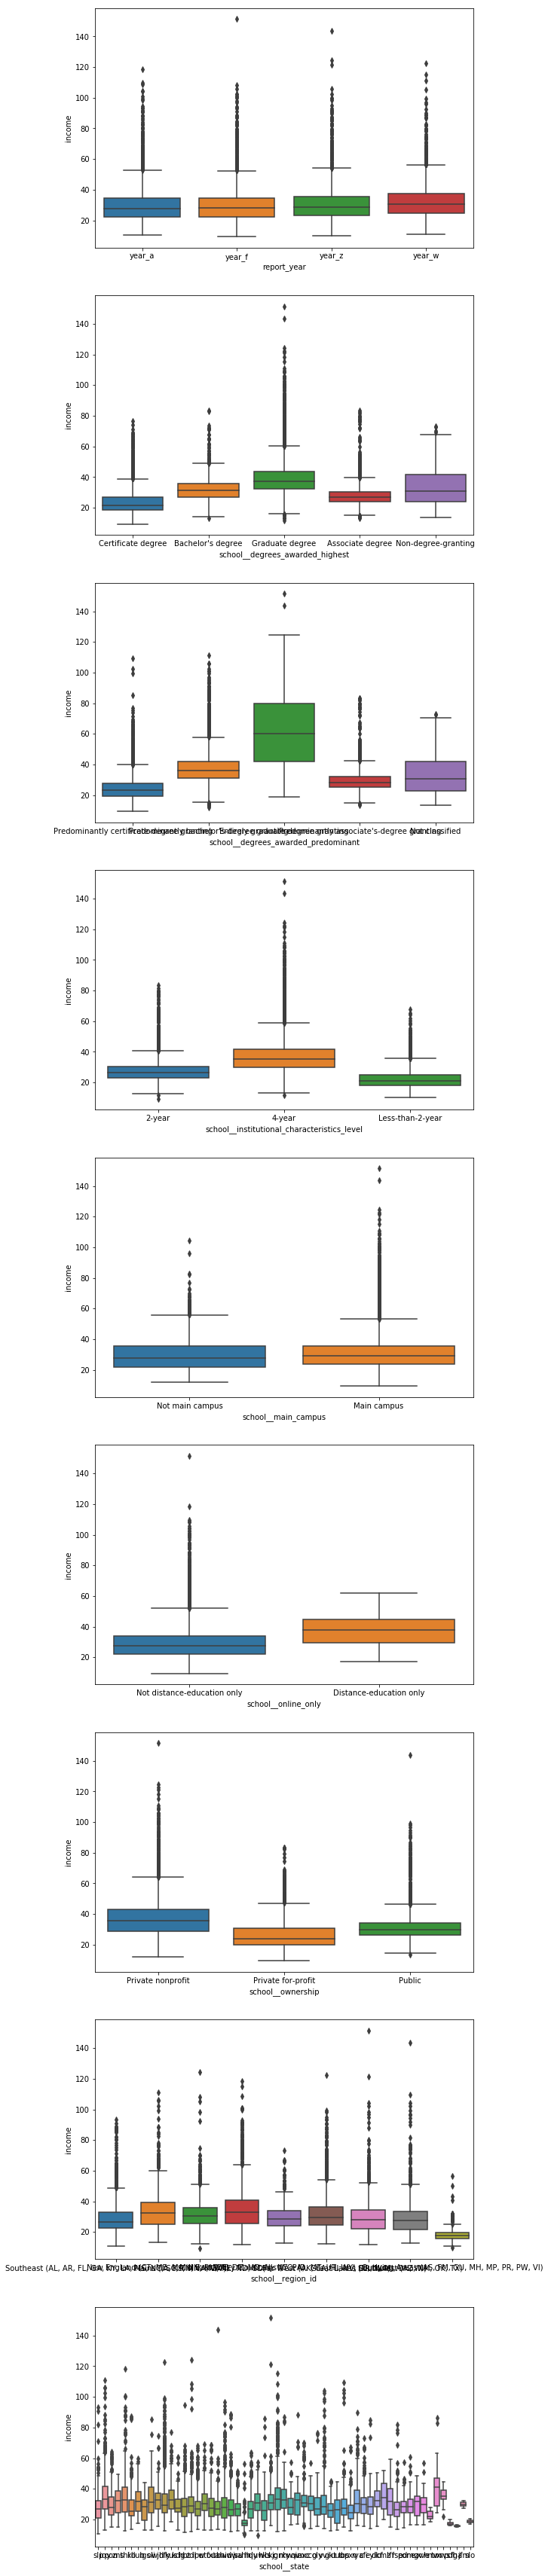

In [225]:
# Check dependency of categorical features and income
X_full = pd.concat([X_train[object_list], y_train], axis=1)

# Set up the matplotlib figure
f, axes = plt.subplots(9, 1, figsize=(9, 62))

for i in np.arange(0,9):
    sns.boxplot(x=X_full.columns.drop('income').tolist()[i], 
                   y='income', 
                   data=X_full, 
                   ax=axes[i])

In [226]:
# Find out features with missing values
X_conc.isnull().sum().sort_values(ascending=True).head(10) / len(X_train)

school__institutional_characteristics_level    0.000000
school__state                                  0.000000
school__main_campus                            0.000000
school__degrees_awarded_predominant_recoded    0.000000
school__degrees_awarded_predominant            0.000000
school__degrees_awarded_highest                0.000000
report_year                                    0.000000
school__region_id                              0.000000
school__ownership                              0.000000
student__demographics_age_entry                0.004384
dtype: float64

In [227]:
# Find out the high correlated features
# Iterative find out features with corr>0.9
X_corr = X_conc.corr()

high_corr = []
for i in range(X_corr.shape[0]):
    for j in range(i+1, X_corr.shape[0]):
        if X_corr.iloc[i,j]>0.9 or X_corr.iloc[i,j]<-0.9:
            high_corr.append(X_corr.iloc[[i],[j]].index[0])
            high_corr.append(X_corr.iloc[[i],[j]].columns[0])

High correlated features: 25


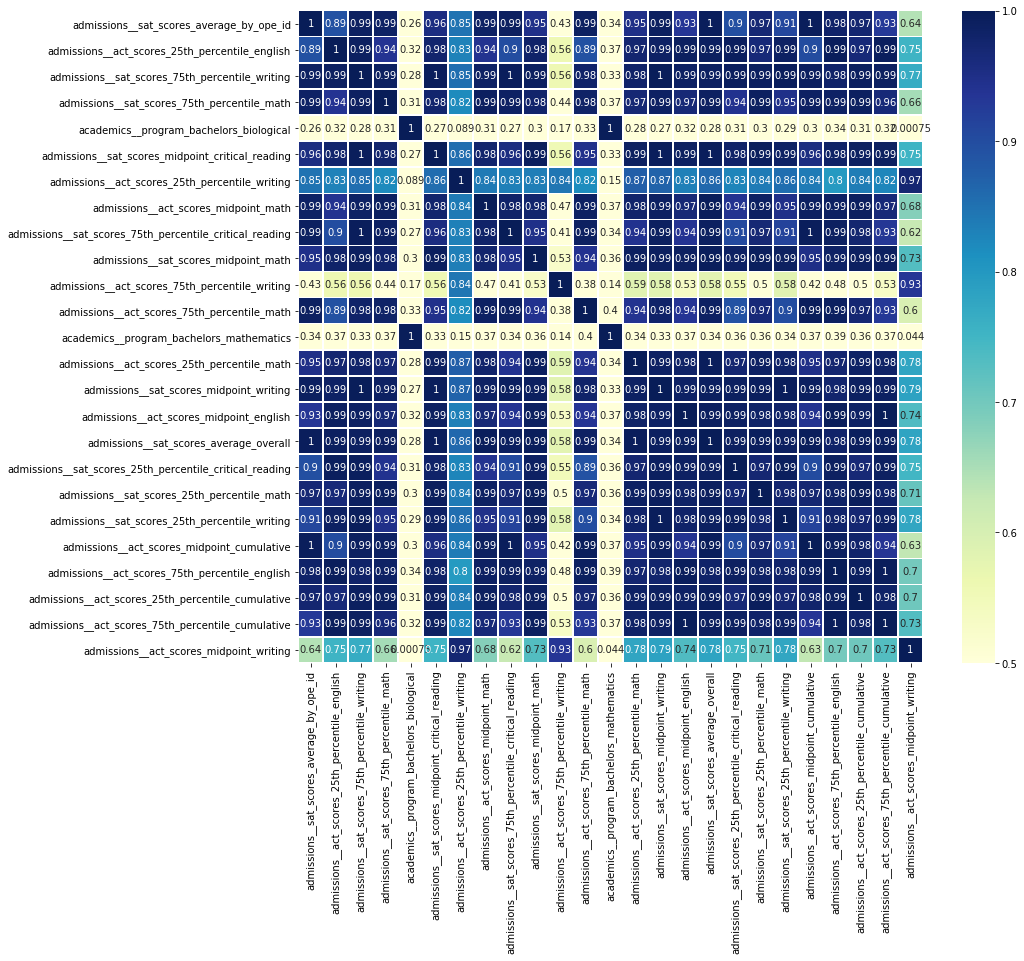

In [228]:
# Sliding out the high correlated features
high_corr = list(set(high_corr))
high_corr.remove('student__share_firstgeneration_parents_middleschool')  # due to 99.51% missing values
print ('High correlated features: ' + str(len(high_corr)))
X_high_corr = X_corr[high_corr].corr().abs()

# Plot heatmap
f, ax = plt.subplots(figsize=(14, 12))

sns.heatmap(X_high_corr, cmap='YlGnBu', vmax=1, vmin=0.5, annot=True,
            linewidths=.5)

#### Identified Quality and Tidiness Issues

##### Quality (Dirty)

- Completeness
    - only 9 of 297 features has no missing value, and 8 of them are categorical features
    - 25 features have high correlation with others
- Validity: none
- Accuracy: none
- Consistency: none

##### Tidiness (Messy): None

##### Learning Algorithm Purpose

- 9 categorical features, and 7 of them has ordinal characteristic

### 1.3 Cleaning

Here only handling missing value and categorical features.

- Define 1: transform categorical feature to ordinal, including `school__online_only` which is the only categorical feature has missing value

In [233]:
type(X_clean['report_year'])

pandas.core.series.Series

In [239]:
##### Code 1 for ordinal transformation #####
def trans_ord(df, col, vmap):
    df[col] = df[col].map(vmap)
    df[col] = pd.to_numeric(df[col], errors='coerce')

X_clean = X_conc.copy()

year_map = {'year_a':1,'year_f':2, 'year_w':3, 'year_z':4}
deg_map = {'Non-degree-granting':0,'Certificate degree':1, 'Associate degree':2, "Bachelor's degree":3, 'Graduate degree':4}
deg_pre_map = {'Not classified':0,'Predominantly certificate-degree granting':1, "Predominantly associate's-degree granting":2,
               "Predominantly bachelor's-degree granting":3, 'Entirely graduate-degree granting':4}
level_map = {'2-year':2,'4-year':4,'Less-than-2-year':0.5}
campus_map = {'Main campus':1,'Not main campus':0}
online_map = {'Not distance-education only':2, 'Distance-education only':1, np.NaN:0}

### Generate dict for State sorted by income median low to high ###
state_income = X_full[['school__state', 'income']].groupby(['school__state']).mean()

# 'nhl' is in test set without income, so estimated by region_id
nhl = X_full[['school__region_id', 'income']].groupby(['school__region_id']).mean().loc['Outlying Areas (AS, FM, GU, MH, MP, PR, PW, VI)',:][0]
state_income.loc['nhl'] = nhl

# Sort and give rank
state_income = state_income.sort_values(by='income')
state_income['rank'] = range(1,59)

# Generate dict for state and rank
state_map = dict(zip(state_income.index.tolist(), state_income['rank'].tolist()))

### Update 7 categorical features to ordinal encoding
trans_ord(X_clean, 'report_year', year_map)
trans_ord(X_clean, 'school__degrees_awarded_highest', deg_map)
trans_ord(X_clean, 'school__degrees_awarded_predominant', deg_pre_map)
trans_ord(X_clean, 'school__institutional_characteristics_level', level_map)
trans_ord(X_clean, 'school__main_campus', campus_map)
trans_ord(X_clean, 'school__online_only', online_map)
trans_ord(X_clean, 'school__state', state_map)

In [257]:
##### Test 1 #####
ord_list = ['report_year','school__degrees_awarded_highest','school__degrees_awarded_predominant','school__institutional_characteristics_level','school__main_campus','school__online_only','school__state']
for i in ord_list:
    print ('Column "' + i + '" consists values: ' + str(X_clean[i].value_counts().index.tolist()))

Column "report_year" consists values: [2, 1, 4, 3]
Column "school__degrees_awarded_highest" consists values: [2, 4, 1, 3, 0]
Column "school__degrees_awarded_predominant" consists values: [1, 3, 2, 0, 4]
Column "school__institutional_characteristics_level" consists values: [4.0, 2.0, 0.5]
Column "school__main_campus" consists values: [1, 0]
Column "school__online_only" consists values: [0, 2, 1]
Column "school__state" consists values: [43, 23, 18, 55, 52, 24, 37, 19, 33, 57, 12, 20, 38, 49, 21, 46, 8, 47, 3, 31, 15, 16, 22, 35, 41, 40, 10, 54, 34, 14, 53, 36, 45, 26, 11, 9, 32, 48, 25, 17, 44, 29, 30, 50, 13, 39, 7, 28, 58, 51, 42, 56, 1, 6, 27, 2, 5, 4]


- Define 2: fill missing values with 0, considering most of the features are sparse.

In [258]:
##### Code 2 #####
X_clean.fillna(value=0, inplace=True)

In [261]:
##### Test 2 #####
X_clean.isnull().sum().sort_values(ascending=False).head(3) / len(X_train)

student__size                                        0.0
academics__program_certificate_lt_1_yr_humanities    0.0
academics__program_certificate_lt_1_yr_legal         0.0
dtype: float64

- Define 3: One-hot encodes the rest 2 categorical data without ordinal encoding

In [265]:
##### Code 3 #####
X_clean = pd.get_dummies(X_clean,columns=['school__ownership','school__region_id'])

In [268]:
##### Test 3 #####
X_clean.dtypes.value_counts()

float64    288
uint8       12
int64        7
dtype: int64

## Step 2: Benchmark Buildup

## Step 3: Interation of Further Data Wrangling

## Step 4: Interation of Feature Engineering

## Step 5: Interation of Single Model Selection